In [2]:
import pandas as pd
import pyvista as pv
from glob import glob
import json
import os
import numpy as np
import cv2
pv.start_xvfb()

In [5]:
tex_info = pd.read_json("/home/aleksandr/mount-folder/3D-FRONT-texture/texture_info.json")

In [6]:
tex_info

,model_id,category,style
0,02ea0d87-1c23-4e22-b384-3eb4845a7d3c,Flooring,Modern
1,02ecd875-5711-4880-b64a-7937edac1d00,Tile,Vintage/Retro
2,08c17716-40b7-4fe0-9c37-d4272b00aaae,Wallpaper,Others
3,0c885c58-5d05-469a-8ffa-24242249aaeb,Tile,American Country
4,0cd57ada-bad0-4076-9165-c8785cc2a092,Wallpaper,Others
...,...,...,...
1419,f22abf6d-1bd5-43a3-a4de-f25c9d9f7b1e,Flooring,Modern
1420,f40e2c56-f3ad-4f92-b415-118470e51742,Paint,Others
1421,f4605928-58e0-4b19-b8f2-fda019fefd33,Tile,American Country
1422,fa216e1e-422f-4068-8d2c-15d419bf66d9,Tile,American Country


In [12]:
tex_room = pv.read_texture("/home/aleksandr/mount-folder/3D-FRONT-texture/273a7787-72f5-4642-b333-03d06526035b/texture.png")

/home/aleksandr/anaconda3/envs/space_match/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


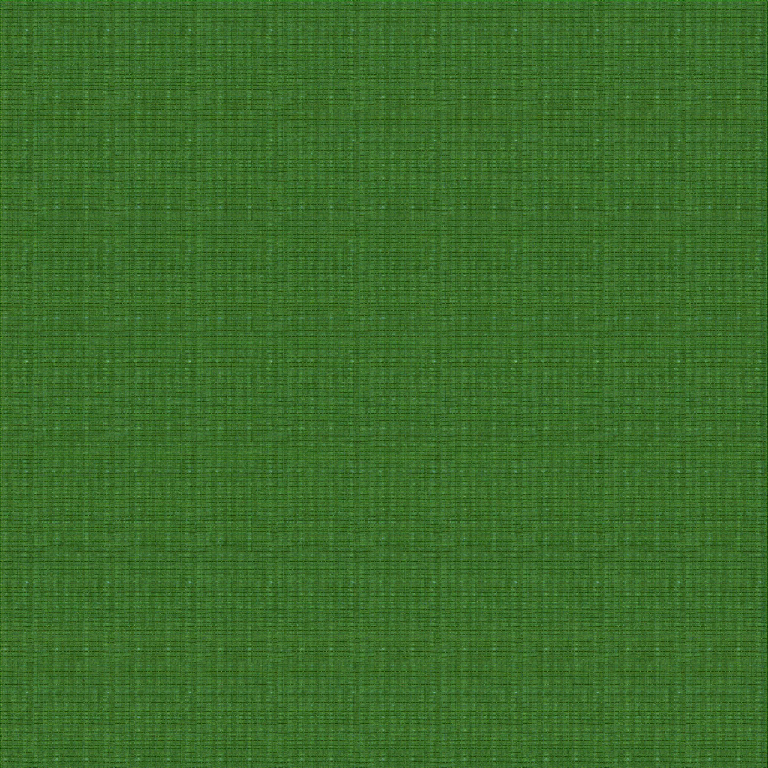

In [14]:
tex_room.plot()

In [10]:
! ls /home/aleksandr/mount-folder/3D-FRONT-texture

273a7787-72f5-4642-b333-03d06526035b  94a587a3-27a4-4766-80d7-156a861bfe53
288bb275-d00f-4638-a6bd-81f578299c32  94c558b9-9920-4d5a-a71b-40c93934df52
28db7d9b-481e-40f2-b551-7b032bd148f2  94dfa325-8cf8-425f-ba72-5f453f148f74
28fa49f2-b4e2-45e7-a2df-2d4dded726a7  95195001-d5c6-43ca-b529-80ecc037b333
28fe7f7d-f82f-4eac-bbab-ef2572c2152e  95810927-0fda-427b-a245-47a492268a20
292c835a-11f1-491b-bf71-02573e361778  9591dfd7-59f1-4edb-9419-77c0ff00c0b4
2931a3fb-caa9-48f1-a809-a35952840d25  95b54ffa-f132-4e5d-9cb0-942e89892e6e
2938eb63-f8ea-47e0-94ca-8de323c2bc43  95f1e2fa-9260-494b-825a-45ecf86e1cf0
29783de1-63f1-4e16-995d-576bc501a1f4  961421b5-a66d-4238-aac5-072e27b84d16
29c59b0c-81de-4b21-b86d-e4a388d347cb  9654026d-06d8-408c-9aaf-454de738e144
29dac7ea-bba8-4314-9308-3cd6685b46f8  9658195c-d084-4e12-bb61-67a2f72353e9
29ed9dfe-724e-42ca-a405-7943d6b3f850  96b6badb-106c-4f7f-a817-03313c28458d
2a135da8-81ae-4b3d-b591-9293efa35a5d  96bf981f-d581-49e8-a886-23f7a706eafe
2a2fa082-fba8-4fe0-ab57-2

In [9]:
! ls /home/aleksandr/mount-folder/3D-FRONT

00110bde-f580-40be-b8bb-88715b338a2a.json
0018b6c8-c3b6-4fb8-a640-4b9b0b763254.json
0032b185-4914-49e5-b973-f82271674308.json
0047c3ab-951b-4182-9082-b9fbf099c142.json
00593e46-062e-4bdd-8ee9-1043387c40f4.json
0071fae9-a2ce-481e-8a37-a2d307e1213d.json
007e1443-462a-4dae-b47c-44cfc6a5a41d.json
008699e0-8d00-40f3-92b4-72347fa892c1.json
00ad8345-45e0-45b3-867d-4a3c88c2517a.json
00b88e19-d106-4ab8-a322-31c494a0a6b9.json
0106f9d2-5779-457b-9b8b-72942373d42e.json
011da194-aa84-4a98-bf9a-afd18357819a.json
01805656-e66f-44b1-8bc1-5e722fff3fff.json
0182566d-2912-4bc1-bd74-70a4e04eb67d.json
01861393-3d82-4926-af4c-e2d29c6d0c0b.json
0192a842-531c-419a-923e-28db4add8656.json
01aa1db0-b73a-4270-807c-1b73268aac3b.json
01df4fc6-be42-4c30-ab7f-0add3ec82213.json
0220ea0d-1475-477e-b88e-ed571e3deed1.json
0235e320-1523-44a5-be6f-20460e3e4a18.json
026d9b2e-f9e3-4754-b234-32e25b1974e5.json
02861dfe-ed53-41f1-b554-b02d0c170c61.json
02b90cf0-5313-425d-961e-3151b633c729.json
02cdd750-72be-4bc5-a033-3c60491900

In [1]:
! cp /home/aleksandr/mount-folder/3D-FRONT/00110bde-f580-40be-b8bb-88715b338a2a.json .

In [10]:
! ls /home/aleksandr/mount-folder/3D-FUTURE-model-part1/0033e020-460c-4990-a2d2-cfe223a2f5a0

001663c3-d459-4fbc-8563-89592fd21d18  6e9b0617-2c4a-43c5-91d7-87e985624e88
0033e020-460c-4990-a2d2-cfe223a2f5a0  6e9e1e84-ca99-4ae0-b082-9feb3f962879
003a85cc-1a58-4b93-8b5c-11ad960aded5  6ea6b90b-a6c5-4d3a-a120-a5bf0ba2869b
0050f47f-0d3e-46c7-8a0d-47a16b524e96  6ea8f314-d956-4d96-b263-a688ad5d9f74
00585bed-3c7b-495a-838e-ff0c35cb03e6  6ead3dc4-3e24-3cb6-a47b-2dbb951fa42a
005bafee-92c1-41db-ac9b-dab97ef3756f  6eb7e186-1e46-42a9-bff7-adb16b671c84
006a08bb-914c-49b9-93ed-4de256ae74c2  6edd8810-b49a-433b-bfa2-c63bbe0c30d8
006c6db0-1477-4340-9163-d08a6cf72738  6ee0382d-4b04-445c-818e-8a0dc3e9450b
006cb2b3-e9e3-34e3-9a0e-f93fa04f344b  6ee22227-ea06-4deb-b2ea-7ffe36e7499c
007498dc-954a-4ddc-b318-164b7e4dfefc  6eef7448-6eac-4830-ba70-913e226b2c51
00775a07-b5c9-4020-94c7-2cd698d668f6  6ef00667-3752-45d3-8f0d-c848c61637c3
007a52b4-27db-4430-b754-4fc5f254e917  6efcbd6c-1ff5-4cb9-bf4d-49f645f5d9a4
00859a4c-8945-4665-92e5-69ab8fba6593  6f00533a-f5d4-44c3-8e20-48d227b537dd
009070c8-1246-4d65-8133-2

In [43]:
! ls /home/aleksandr/mount-folder/3D-FUTURE-model-part1 

In [4]:
f = open("existing_models.txt")
existing_model_ids = set(f.read().split("\n"))

In [5]:
model_info = pd.read_json("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/model_info.json")
model_info

,model_id,super-category,category,style,theme,material
0,f89da2db-ad8c-4582-b186-ed2a46f3cb15,Sofa,armchair,Minimalist,Gold Foil,Rough Cloth
1,5de45849-7d1b-4378-82da-ed183b7ecc37,Chair,Lounge Chair / Cafe Chair / Office Chair,Ming Qing,Floral,Rough Cloth
2,1ef668a9-12e0-447b-9bbc-8ae484ba8c58,Lighting,Pendant Lamp,Modern,None,None
3,0d3e3b3c-3f1a-47ee-8566-1052cb8635b6,Cabinet/Shelf/Desk,Coffee Table,Modern,Texture Mark,Wood
4,16febe29-52d9-4833-a695-b09446e65512,Cabinet/Shelf/Desk,Corner/Side Table,Modern,Cartoon,Composite Board
...,...,...,...,...,...,...
16558,328918d2-1121-4f2e-bb63-fb1ecadc687a,Others,None,Modern,None,None
16559,5e5c01c1-e9a0-4eff-a059-0c9ea5afae9c,Lighting,Ceiling Lamp,Modern,None,None
16560,908e38ac-35ca-4aa2-ad9f-8402fc7ae8ed,Others,None,Modern,None,None
16561,966e026d-c284-438e-99a1-2baba6379d3f,Others,None,Modern,None,None


In [6]:
# model_info.groupby("super-category")["category"].unique().explode()

In [7]:
n = 3
dir = "/home/aleksandr/mount-folder/3D-FUTURE-model-part1"
# model_ids = existing_model_ids & set(model_info["model_id"])
model_ids = existing_model_ids & set(model_info[model_info["category"] == "King-size Bed"]["model_id"])
model_ids = list(model_ids)
models = []
for name in model_ids[:n]:
    f = os.path.join(dir, name)
    models.append({
        "model": pv.read(os.path.join(f, "normalized_model.obj")),
        "texture": pv.read_texture(os.path.join(f, "texture.png"))
    })
# m = pv.read("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/ffde330f-dce0-4215-bfe6-203fe615b609/raw_model.obj")
# norm_m = pv.read("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/ffde330f-dce0-4215-bfe6-203fe615b609/normalized_model.obj")
# tex = pv.read_texture("/home/aleksandr/mount-folder/3D-FUTURE-model-part1/ffde330f-dce0-4215-bfe6-203fe615b609/texture.png")

In [ ]:
def crop_object(image_array):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    gray = np.where(gray==255, 0, gray)

    # # Find contours in the binary mask
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # Find the largest contour (assumed to be the object)
    largest_contour = max(contours, key=cv2.contourArea).squeeze()

    bottom_right = largest_contour.max(0)
    top_left = largest_contour.min(0)

    # TODO: add boundaries checker
    cropped_image_array = image_array[top_left[1]: bottom_right[1] + 1,
                                      top_left[0]: bottom_right[0] + 1, :]
    return cropped_image_array

def create_views(mesh, texture, camera_distance=5, positions=None):
    if not positions:
        positions = [
            [(0, camera_distance, 0), (0, 0, 0), (0, 0, -1)],
            [(0, -camera_distance, 0), (0, 0, 0), (0, 0, -1)],
            [(0, 0, camera_distance), (0, 0, 0), (0, 1, 0)],
            [(-camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
            [(camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
            [(0, 0, -camera_distance), (0, 0, 0), (0, 1, 0)],
        ]
    model_views = []
    for position in positions:
        pl = pv.Plotter()
        pl.camera_position = position
        no_transp_texture = pv.numpy_to_texture(texture.to_array()[..., :3])
        pl.add_mesh(mesh, texture=no_transp_texture)
        model_views.append(crop_object(pl.screenshot(return_img=True)))
    return model_views

In [123]:
views = create_views(models[0]["model"], models[0]["texture"])

In [125]:
# # axes = pv.Axes(show_actor=True, actor_scale=1.0)
# camera_distance=5

# # front_view_camera_position = np.array([(0, -camera_distance, 0), (0, 0, 0), (0, 0, 1)])
# # rotated_camera_position = front_view_camera_position.dot(np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]]))
# # plotter.camera_position = rotated_camera_position
# positions = [
#     [(0, camera_distance, 0), (0, 0, 0), (0, 0, -1)],
#     [(0, -camera_distance, 0), (0, 0, 0), (0, 0, -1)],
#     [(0, 0, camera_distance), (0, 0, 0), (0, 1, 0)],
#     [(-camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
#     [(camera_distance, 0, 0), (0, 0, 0), (0, 1, 0)],
#     [(0, 0, -camera_distance), (0, 0, 0), (0, 1, 0)],
# ]
# views = []
# for m in models:
# #     pl.camera_position = [(3.2257270137110754, 3.640847078923325, 3.2256104866305395),
# #  (0.0, 0.41512006521224976, -0.00011652708053588867),
# #  (0.0, 0.0, 1.0)]
#     # pl.camera.zoom(0.3)
#     # pl.add_actor(axes.actor)
#     one_model_views = []
#     for position in positions:
#         pl = pv.Plotter()
#         pl.camera_position = position
#         pl.add_mesh(m["model"], texture=m["texture"])
#         # pl.add_texture(texture=m["texture"])
#         one_model_views.append(crop_object(pl.screenshot(return_img=True)))
#     views.append(one_model_views)

In [38]:
models[2]["texture"].opacity=1

In [30]:
p = models[0]["texture"].to_array()
t = pv.numpy_to_texture(np.stack([p[..., 0],p[..., 1], p[..., 2] ], -1))

/home/aleksandr/anaconda3/envs/space_match/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(


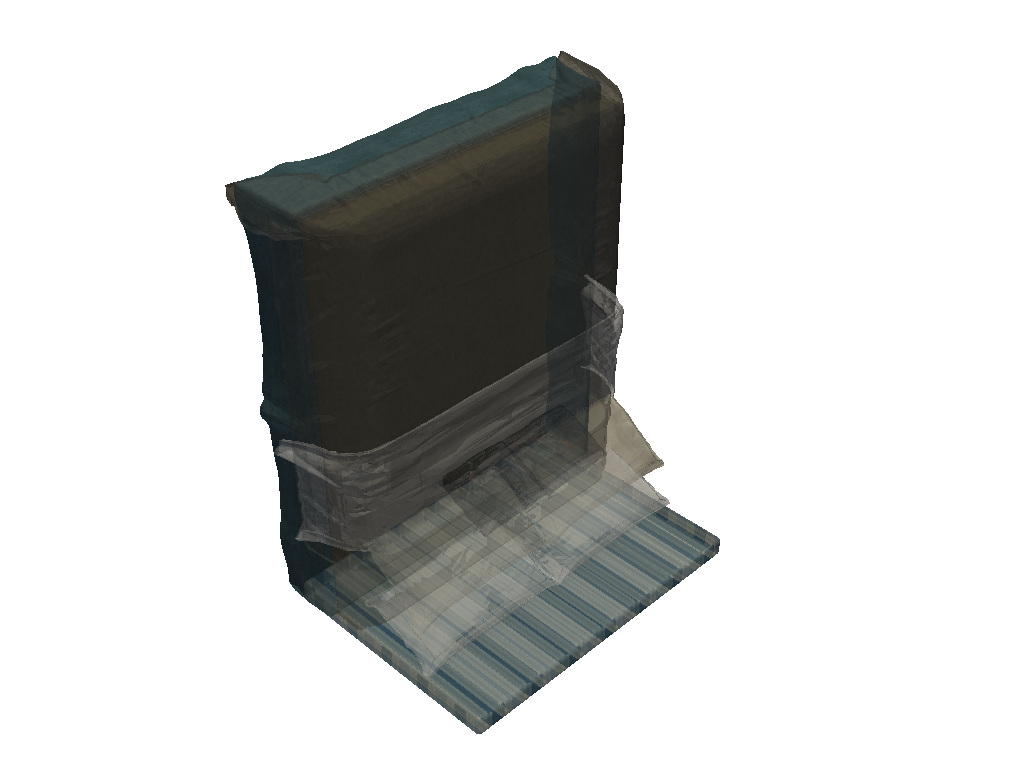

In [39]:
        pl = pv.Plotter()
        # pl.camera_position = position
        pl.add_mesh(models[2]["model"], texture=models[2]["texture"])
        pl.show()

In [113]:
np.array(models[1]["texture"].to_array())[[..., 3]]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0, 124],
       [200, 255, 255, ...,   0,   0,  58],
       [ 67, 137, 137, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
models[1]["texture"].t

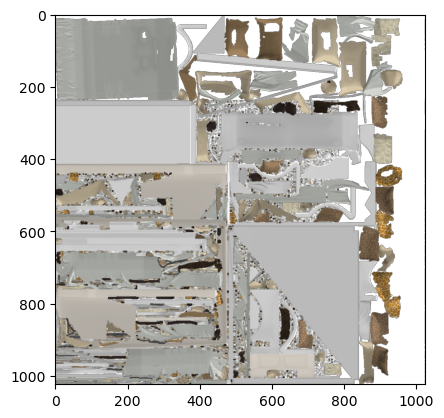

In [110]:
plt.imshow(np.array(models[1]["texture"].to_array()))

TypeError: Image data of dtype object cannot be converted to float

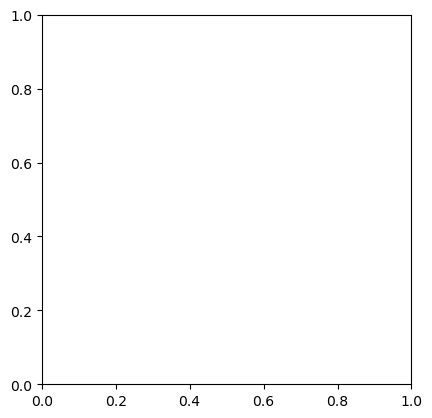

In [124]:
plt.imshow(models[0]["texture"])

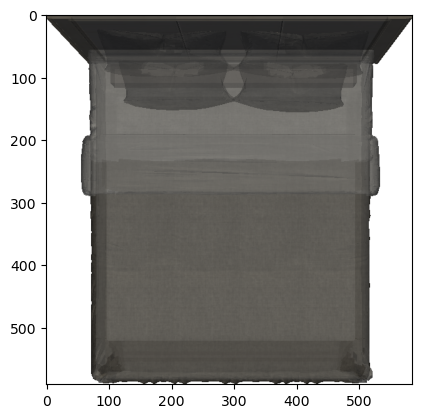

In [88]:
plt.imshow(views[0])

In [46]:
gray.max()

185

In [64]:
max_thresh = largest_contour.squeeze().max(0)
min_thresh = largest_contour.squeeze().min(0)

In [56]:
views[0][1].shape

(768, 1024, 3)

In [65]:
max_thresh

array([774, 623], dtype=int32)

In [66]:
min_thresh[0], max_thresh[0]

(300, 774)

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[ 38,  49,  56],
                  [ 38,  49,  56],
                  [ 38,  49,  56],
                  ...,
                  [ 38,  49,  56],
                  [ 38,  49,  56],
                  [ 38,  49,  56]],

                 [[ 49,  61,  64],
                  [ 38,  49,  56],
                  [ 38,  49,  56],
                  ...,
                  [ 38,  49,  56],
                  [ 38,  49,  56],
                  [ 38,  49,  56]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

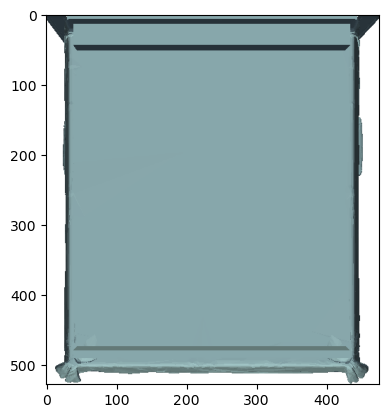

In [69]:
plt.imshow(views[0][1][min_thresh[1]: max_thresh[1] + 1, min_thresh[0]: max_thresh[0] + 1, :])
